# 개선된 KMeans 군집 분석
## 건강 패턴 그룹화 및 특성 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

print("라이브러리 로드 완료")

라이브러리 로드 완료


In [2]:
# 데이터 로드 및 전처리
df = pd.read_csv('./data/health_2023_cleaned_final.csv')

# 군집분석에 사용할 건강지표 선택
cluster_features = [
    '연령대코드(5세단위)', '성별코드', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
    '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
    '총콜레스테롤', 'HDL콜레스테롤', 'LDL콜레스테롤', '트리글리세라이드',
    '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피',
    '혈청크레아티닌', '흡연상태', '음주여부'
]

# 결측치 제거
df_cluster = df[cluster_features].dropna()
print(f"군집분석용 데이터 크기: {df_cluster.shape}")

# 파생 변수 추가
df_cluster['BMI'] = (df.loc[df_cluster.index, '체중(5kg단위)'] * 1.0) / ((df.loc[df_cluster.index, '신장(5cm단위)'] / 100) ** 2)
df_cluster['허리신장비'] = df_cluster['허리둘레'] / df_cluster['신장(5cm단위)']

# 최종 특성 리스트
final_features = cluster_features + ['BMI', '허리신장비']
df_cluster = df_cluster[final_features].fillna(df_cluster[final_features].mean())

print(f"최종 특성 개수: {len(final_features)}")
print(f"특성 목록: {final_features}")

군집분석용 데이터 크기: (332650, 18)
최종 특성 개수: 20
특성 목록: ['연령대코드(5세단위)', '성별코드', '신장(5cm단위)', '체중(5kg단위)', '허리둘레', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', 'HDL콜레스테롤', 'LDL콜레스테롤', '트리글리세라이드', '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피', '혈청크레아티닌', '흡연상태', '음주여부', 'BMI', '허리신장비']


## 1. 최적 클러스터 수 결정

In [3]:
# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
print(f"정규화된 데이터 형태: {X_scaled.shape}")

# 샘플링 (계산 시간 단축을 위해)
sample_size = min(10000, len(X_scaled))
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]
df_sample = df_cluster.iloc[sample_indices]

print(f"샘플링된 데이터 크기: {X_sample.shape}")

정규화된 데이터 형태: (332650, 20)
샘플링된 데이터 크기: (10000, 20)


클러스터 수별 평가 진행 중...
k=2: Inertia=180395.83, Silhouette Score=0.167
k=2: Inertia=180395.83, Silhouette Score=0.167
k=3: Inertia=167400.86, Silhouette Score=0.168
k=3: Inertia=167400.86, Silhouette Score=0.168
k=4: Inertia=156876.54, Silhouette Score=0.125
k=4: Inertia=156876.54, Silhouette Score=0.125
k=5: Inertia=147784.39, Silhouette Score=0.120
k=5: Inertia=147784.39, Silhouette Score=0.120
k=6: Inertia=138356.39, Silhouette Score=0.114
k=6: Inertia=138356.39, Silhouette Score=0.114
k=7: Inertia=132173.58, Silhouette Score=0.117
k=7: Inertia=132173.58, Silhouette Score=0.117
k=8: Inertia=128416.69, Silhouette Score=0.110
k=8: Inertia=128416.69, Silhouette Score=0.110
k=9: Inertia=124082.01, Silhouette Score=0.101
k=9: Inertia=124082.01, Silhouette Score=0.101
k=10: Inertia=120820.22, Silhouette Score=0.104
k=10: Inertia=120820.22, Silhouette Score=0.104


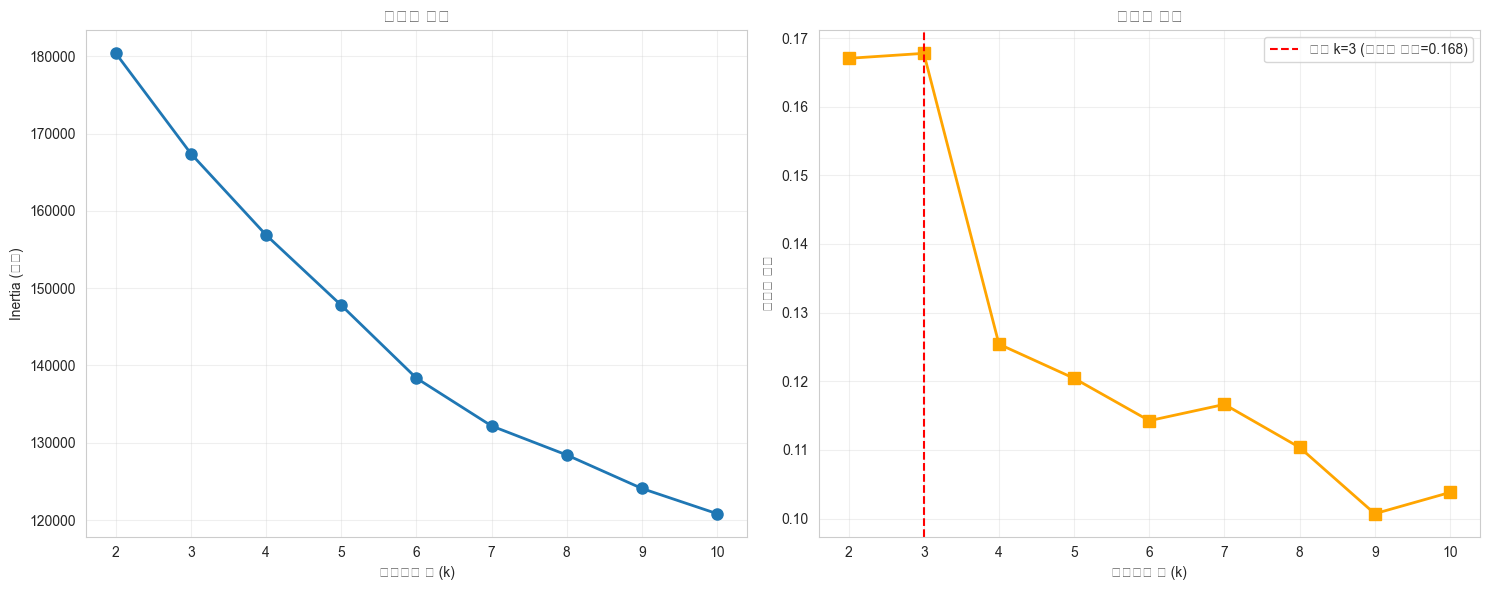


최적 클러스터 수: 3
최고 실루엣 점수: 0.168


In [4]:
# 엘보우 방법과 실루엣 분석으로 최적 클러스터 수 결정
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("클러스터 수별 평가 진행 중...")
for k in k_range:
    # KMeans 실행
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_sample)
    
    # 평가 지표 계산
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.3f}")

# 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 엘보우 방법
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('클러스터 수 (k)')
axes[0].set_ylabel('Inertia (관성)')
axes[0].set_title('엘보우 방법')
axes[0].grid(True, alpha=0.3)

# 실루엣 점수
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('클러스터 수 (k)')
axes[1].set_ylabel('실루엣 점수')
axes[1].set_title('실루엣 분석')
axes[1].grid(True, alpha=0.3)

# 최적 k 표시
optimal_k = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=optimal_k, color='red', linestyle='--', 
               label=f'최적 k={optimal_k} (실루엣 점수={max(silhouette_scores):.3f})')
axes[1].legend()

plt.tight_layout()
plt.savefig('./plots/optimal_clusters_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n최적 클러스터 수: {optimal_k}")
print(f"최고 실루엣 점수: {max(silhouette_scores):.3f}")

## 2. 최종 군집분석 수행

In [5]:
# 최적 클러스터 수로 최종 군집분석 수행
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_sample)

# 결과를 데이터프레임에 추가
df_clustered = df_sample.copy()
df_clustered['클러스터'] = cluster_labels

print(f"클러스터별 데이터 분포:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = count / len(cluster_labels) * 100
    print(f"클러스터 {cluster_id}: {count:,}명 ({percentage:.1f}%)")

# 실루엣 분석
silhouette_avg = silhouette_score(X_sample, cluster_labels)
sample_silhouette_values = silhouette_samples(X_sample, cluster_labels)

print(f"\n평균 실루엣 점수: {silhouette_avg:.3f}")

클러스터별 데이터 분포:
클러스터 0: 5,056명 (50.6%)
클러스터 1: 4,939명 (49.4%)
클러스터 2: 5명 (0.1%)

평균 실루엣 점수: 0.168

평균 실루엣 점수: 0.168


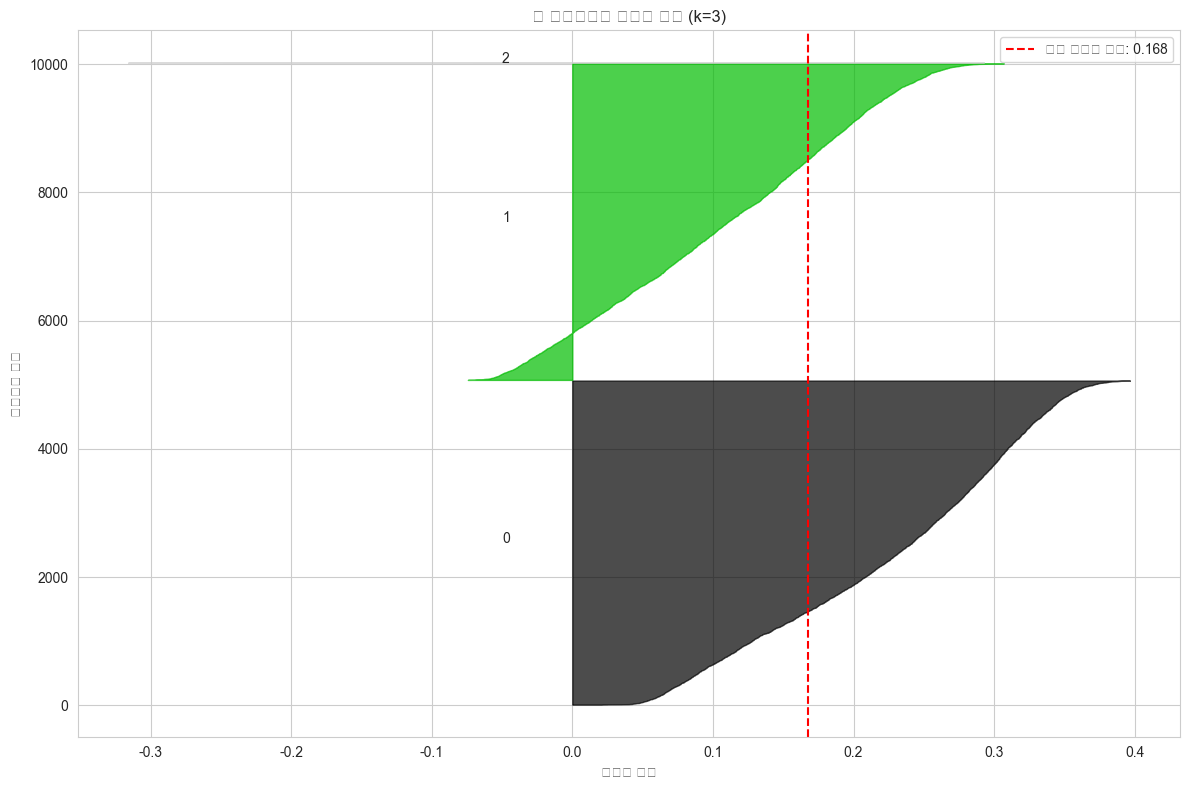

In [6]:
# 실루엣 플롯
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

y_lower = 10
colors = plt.cm.nipy_spectral(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    # i번째 클러스터의 실루엣 점수들
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = colors[i]
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # 클러스터 라벨 표시
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel('실루엣 계수')
ax.set_ylabel('클러스터 라벨')
ax.set_title(f'각 클러스터별 실루엣 분석 (k={optimal_k})')

# 전체 평균 실루엣 점수 선 표시
ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
          label=f'평균 실루엣 점수: {silhouette_avg:.3f}')
ax.legend()

plt.tight_layout()
plt.savefig('./plots/silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. 클러스터별 특성 분석

In [7]:
# 클러스터별 주요 건강지표 평균값 계산
key_health_indicators = [
    '연령대코드(5세단위)', '성별코드', 'BMI', '허리둘레',
    '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
    '총콜레스테롤', 'HDL콜레스테롤', 'LDL콜레스테롤', '트리글리세라이드',
    '흡연상태', '음주여부'
]

cluster_stats = df_clustered.groupby('클러스터')[key_health_indicators].agg(['mean', 'std']).round(2)

print("=== 클러스터별 주요 건강지표 통계 ===")
for cluster_id in range(optimal_k):
    print(f"\n[클러스터 {cluster_id}] (n={cluster_counts[cluster_id]:,}명)")
    cluster_data = cluster_stats.loc[cluster_id]
    
    # 주요 지표만 출력
    important_vars = ['연령대코드(5세단위)', 'BMI', '총콜레스테롤', '수축기혈압', '식전혈당(공복혈당)']
    for var in important_vars:
        mean_val = cluster_data[(var, 'mean')]
        std_val = cluster_data[(var, 'std')]
        print(f"  {var}: {mean_val:.1f} ± {std_val:.1f}")

# 상세 통계표 저장
cluster_stats.to_csv('./plots/cluster_statistics.csv')
print("\n상세 통계표가 './plots/cluster_statistics.csv'에 저장되었습니다.")

=== 클러스터별 주요 건강지표 통계 ===

[클러스터 0] (n=5,056명)
  연령대코드(5세단위): 12.2 ± 2.6
  BMI: 22.5 ± 3.0
  총콜레스테롤: 197.2 ± 41.1
  수축기혈압: 122.1 ± 15.0
  식전혈당(공복혈당): 98.8 ± 20.0

[클러스터 1] (n=4,939명)
  연령대코드(5세단위): 10.6 ± 2.9
  BMI: 26.1 ± 3.6
  총콜레스테롤: 193.5 ± 42.4
  수축기혈압: 127.1 ± 13.6
  식전혈당(공복혈당): 105.5 ± 26.3

[클러스터 2] (n=5명)
  연령대코드(5세단위): 12.2 ± 3.1
  BMI: 22.8 ± 2.5
  총콜레스테롤: 261.6 ± 211.9
  수축기혈압: 123.2 ± 10.8
  식전혈당(공복혈당): 114.0 ± 29.6

상세 통계표가 './plots/cluster_statistics.csv'에 저장되었습니다.


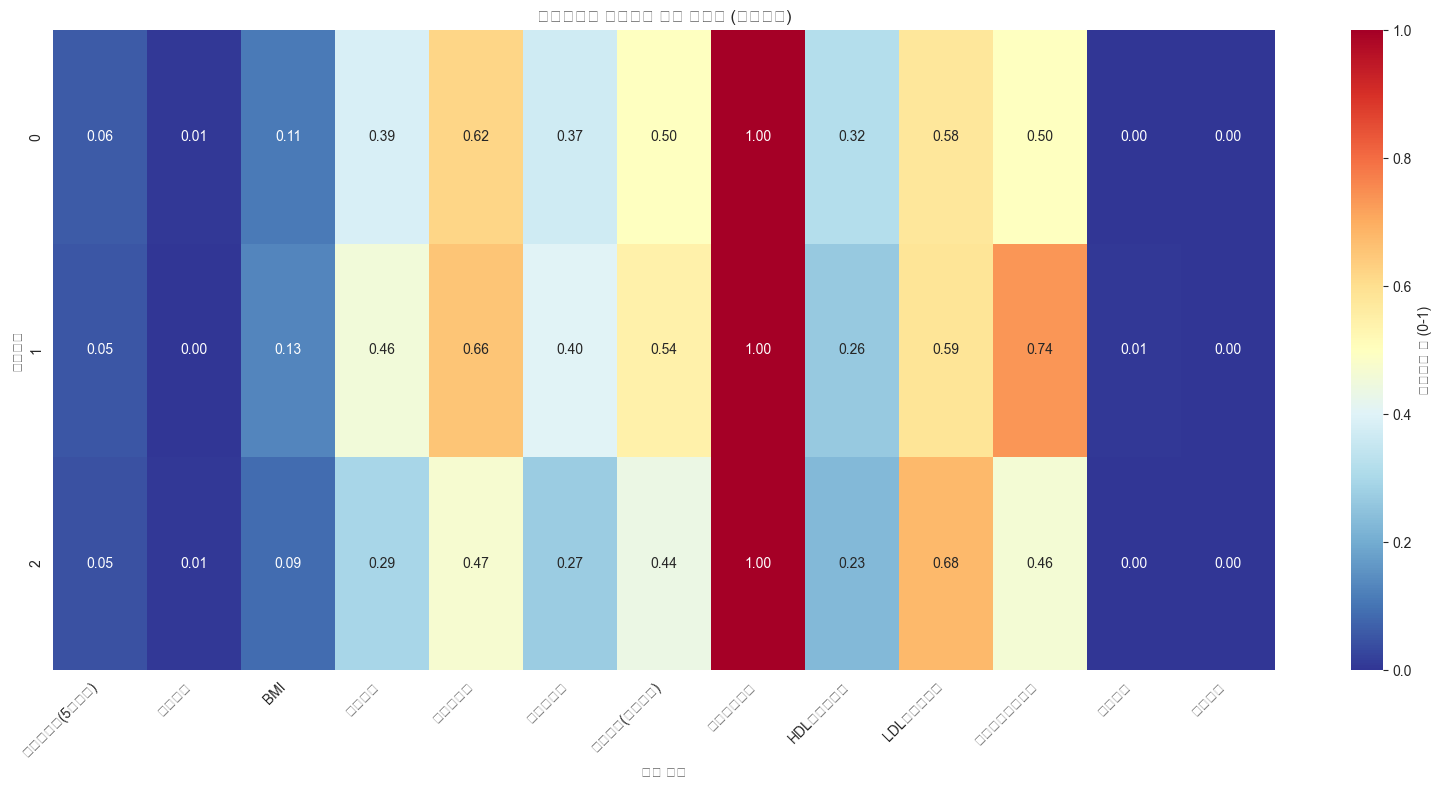

In [8]:
# 클러스터별 특성 히트맵
cluster_means = df_clustered.groupby('클러스터')[key_health_indicators].mean()

# 정규화 (0-1 스케일링)
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(
    scaler_viz.fit_transform(cluster_means.T).T,
    index=cluster_means.index,
    columns=cluster_means.columns
)

plt.figure(figsize=(16, 8))
sns.heatmap(cluster_means_normalized, 
            annot=True, 
            cmap='RdYlBu_r', 
            fmt='.2f',
            cbar_kws={'label': '정규화된 값 (0-1)'})
plt.title('클러스터별 건강지표 특성 히트맵 (정규화됨)')
plt.xlabel('건강 지표')
plt.ylabel('클러스터')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./plots/cluster_characteristics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 클러스터 시각화

PCA 제1주성분 설명 분산: 0.233
PCA 제2주성분 설명 분산: 0.133
총 설명 분산: 0.366


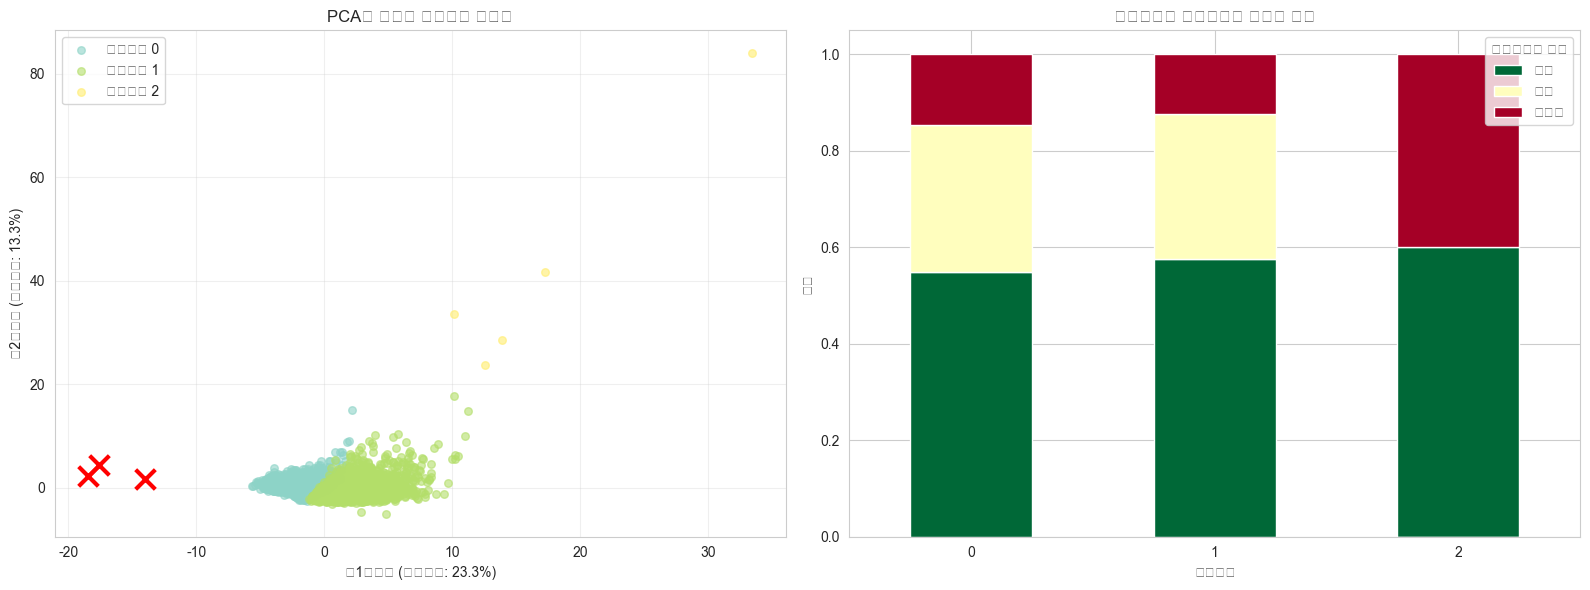

In [9]:
# PCA를 사용한 차원 축소 및 시각화
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)

# PCA 설명 분산 비율
explained_variance = pca.explained_variance_ratio_
print(f"PCA 제1주성분 설명 분산: {explained_variance[0]:.3f}")
print(f"PCA 제2주성분 설명 분산: {explained_variance[1]:.3f}")
print(f"총 설명 분산: {sum(explained_variance):.3f}")

# 클러스터별 PCA 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 클러스터별 색상 구분
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
for cluster_id in range(optimal_k):
    mask = cluster_labels == cluster_id
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[colors[cluster_id]], 
                   label=f'클러스터 {cluster_id}',
                   alpha=0.6, s=30)

axes[0].set_xlabel(f'제1주성분 (설명분산: {explained_variance[0]:.1%})')
axes[0].set_ylabel(f'제2주성분 (설명분산: {explained_variance[1]:.1%})')
axes[0].set_title('PCA를 이용한 클러스터 시각화')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 클러스터 중심점 표시
centroids_pca = pca.transform(scaler.transform(pd.DataFrame(final_kmeans.cluster_centers_, columns=final_features)))
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
               c='red', marker='x', s=200, linewidths=3, label='중심점')

# 주요 건강지표별 분포 (박스플롯)
df_clustered['총콜레스테롤_그룹'] = pd.cut(df_clustered['총콜레스테롤'], 
                                   bins=[0, 200, 240, 1000], 
                                   labels=['정상', '경계', '고위험'])

# 클러스터별 콜레스테롤 위험도 분포
crosstab = pd.crosstab(df_clustered['클러스터'], df_clustered['총콜레스테롤_그룹'], normalize='index')
crosstab.plot(kind='bar', stacked=True, ax=axes[1], colormap='RdYlGn_r')
axes[1].set_title('클러스터별 콜레스테롤 위험도 분포')
axes[1].set_xlabel('클러스터')
axes[1].set_ylabel('비율')
axes[1].legend(title='콜레스테롤 수준')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('./plots/cluster_visualization_pca.png', dpi=300, bbox_inches='tight')
plt.show()

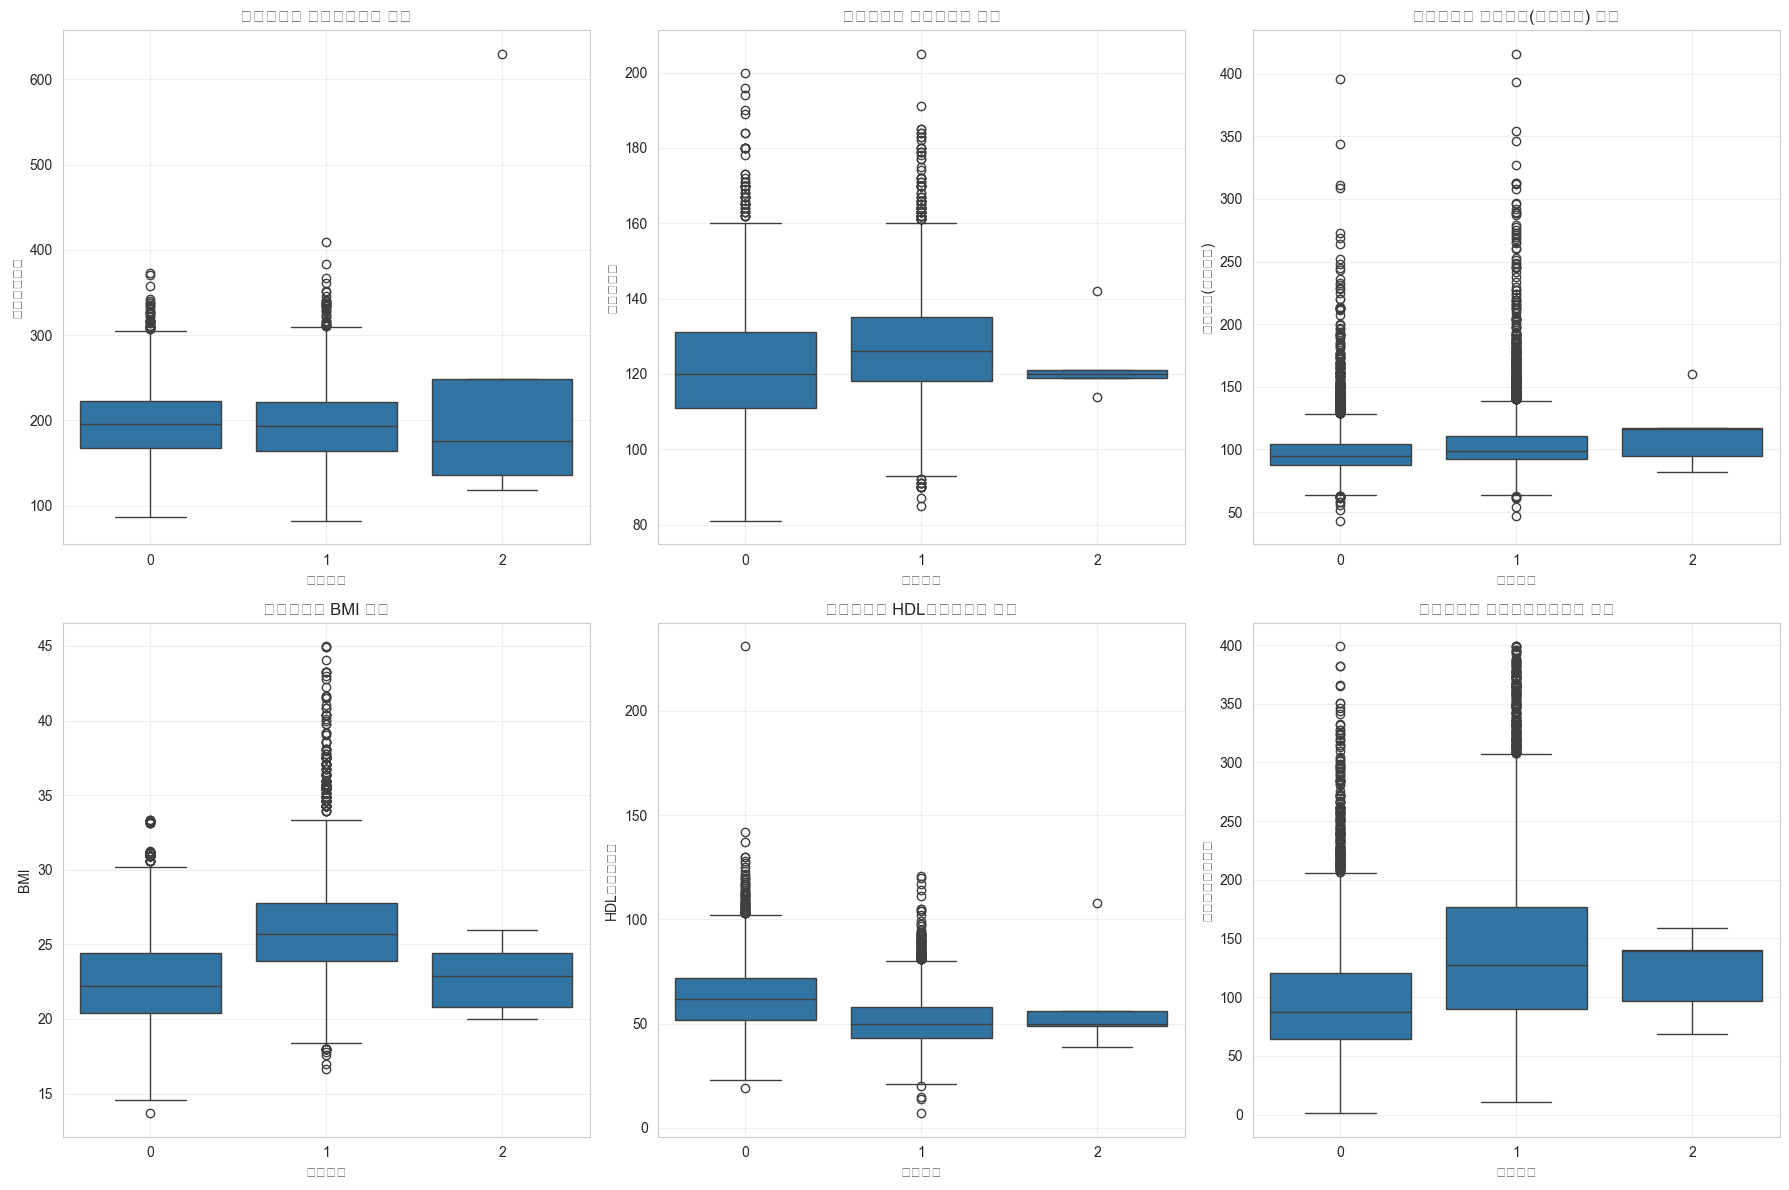

In [10]:
# 클러스터별 주요 건강지표 분포 비교
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

health_vars_to_plot = [
    '총콜레스테롤', '수축기혈압', '식전혈당(공복혈당)', 
    'BMI', 'HDL콜레스테롤', '트리글리세라이드'
]

for idx, var in enumerate(health_vars_to_plot):
    sns.boxplot(data=df_clustered, x='클러스터', y=var, ax=axes[idx])
    axes[idx].set_title(f'클러스터별 {var} 분포')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/cluster_health_indicators_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. 클러스터 프로파일링

In [11]:
# 클러스터별 특성 요약 및 명명
cluster_profiles = {}

for cluster_id in range(optimal_k):
    cluster_data = df_clustered[df_clustered['클러스터'] == cluster_id]
    
    profile = {
        '인원수': len(cluster_data),
        '비율': len(cluster_data) / len(df_clustered) * 100,
        '평균연령대': cluster_data['연령대코드(5세단위)'].mean(),
        '남성비율': (cluster_data['성별코드'] == 1).mean() * 100,
        '평균BMI': cluster_data['BMI'].mean(),
        '평균총콜레스테롤': cluster_data['총콜레스테롤'].mean(),
        '평균수축기혈압': cluster_data['수축기혈압'].mean(),
        '평균공복혈당': cluster_data['식전혈당(공복혈당)'].mean(),
        '흡연자비율': (cluster_data['흡연상태'] == 3).mean() * 100,
        '음주자비율': (cluster_data['음주여부'] == 1).mean() * 100,
        '고콜레스테롤비율': (cluster_data['총콜레스테롤'] >= 240).mean() * 100,
        '고혈압비율': ((cluster_data['수축기혈압'] >= 140) | (cluster_data['이완기혈압'] >= 90)).mean() * 100,
        '당뇨위험비율': (cluster_data['식전혈당(공복혈당)'] >= 100).mean() * 100
    }
    
    cluster_profiles[cluster_id] = profile

# 프로파일 데이터프레임 생성
profile_df = pd.DataFrame(cluster_profiles).T
profile_df = profile_df.round(1)

print("=== 클러스터별 상세 프로파일 ===")
print(profile_df)

# CSV로 저장
profile_df.to_csv('./plots/cluster_profiles.csv')
print("\n클러스터 프로파일이 './plots/cluster_profiles.csv'에 저장되었습니다.")

=== 클러스터별 상세 프로파일 ===
      인원수    비율  평균연령대  남성비율  평균BMI  평균총콜레스테롤  평균수축기혈압  평균공복혈당  흡연자비율  음주자비율  \
0  5056.0  50.6   12.2  17.0   22.5     197.2    122.1    98.8    4.9   45.3   
1  4939.0  49.4   10.6  92.4   26.1     193.5    127.1   105.5   32.2   78.5   
2     5.0   0.0   12.2  20.0   22.8     261.6    123.2   114.0    0.0   20.0   

   고콜레스테롤비율  고혈압비율  당뇨위험비율  
0      15.2   13.5    35.7  
1      13.0   19.2    49.9  
2      40.0   20.0    60.0  

클러스터 프로파일이 './plots/cluster_profiles.csv'에 저장되었습니다.


In [12]:
# 클러스터 특성에 따른 명명
def name_cluster(cluster_id, profile):
    """클러스터 특성에 따라 의미있는 이름 부여"""
    avg_age = profile['평균연령대']
    avg_bmi = profile['평균BMI']
    high_chol_rate = profile['고콜레스테롤비율']
    high_bp_rate = profile['고혈압비율']
    diabetes_risk_rate = profile['당뇨위험비율']
    
    # 연령대 분류
    if avg_age < 8:  # 40대 미만
        age_group = "청년층"
    elif avg_age < 12:  # 60대 미만
        age_group = "중년층"
    else:
        age_group = "고령층"
    
    # 건강상태 분류
    if high_chol_rate < 10 and high_bp_rate < 20 and diabetes_risk_rate < 30:
        health_status = "건강양호군"
    elif high_chol_rate >= 30 or high_bp_rate >= 40 or diabetes_risk_rate >= 60:
        health_status = "고위험군"
    else:
        health_status = "중간위험군"
    
    return f"{age_group}_{health_status}"

# 클러스터별 명명
cluster_names = {}
for cluster_id in range(optimal_k):
    profile = cluster_profiles[cluster_id]
    name = name_cluster(cluster_id, profile)
    cluster_names[cluster_id] = name

print("=== 클러스터 명명 결과 ===")
for cluster_id, name in cluster_names.items():
    profile = cluster_profiles[cluster_id]
    print(f"\n클러스터 {cluster_id}: {name}")
    print(f"  - 인원: {profile['인원수']:,}명 ({profile['비율']:.1f}%)")
    print(f"  - 평균 연령대: {profile['평균연령대']:.1f} (약 {int(profile['평균연령대']*5 + 20)}세)")
    print(f"  - 평균 BMI: {profile['평균BMI']:.1f}")
    print(f"  - 고콜레스테롤 비율: {profile['고콜레스테롤비율']:.1f}%")
    print(f"  - 고혈압 비율: {profile['고혈압비율']:.1f}%")
    print(f"  - 당뇨 위험 비율: {profile['당뇨위험비율']:.1f}%")

# 명명된 클러스터 정보를 파일로 저장
cluster_summary = pd.DataFrame({
    '클러스터ID': list(cluster_names.keys()),
    '클러스터명': list(cluster_names.values()),
    '인원수': [cluster_profiles[i]['인원수'] for i in cluster_names.keys()],
    '비율(%)': [cluster_profiles[i]['비율'] for i in cluster_names.keys()]
})

cluster_summary.to_csv('./plots/cluster_summary.csv', index=False)
print("\n클러스터 요약이 './plots/cluster_summary.csv'에 저장되었습니다.")

=== 클러스터 명명 결과 ===

클러스터 0: 고령층_중간위험군
  - 인원: 5,056명 (50.6%)
  - 평균 연령대: 12.2 (약 80세)
  - 평균 BMI: 22.5
  - 고콜레스테롤 비율: 15.2%
  - 고혈압 비율: 13.5%
  - 당뇨 위험 비율: 35.7%

클러스터 1: 중년층_중간위험군
  - 인원: 4,939명 (49.4%)
  - 평균 연령대: 10.6 (약 73세)
  - 평균 BMI: 26.1
  - 고콜레스테롤 비율: 13.0%
  - 고혈압 비율: 19.2%
  - 당뇨 위험 비율: 49.9%

클러스터 2: 고령층_고위험군
  - 인원: 5명 (0.1%)
  - 평균 연령대: 12.2 (약 81세)
  - 평균 BMI: 22.8
  - 고콜레스테롤 비율: 40.0%
  - 고혈압 비율: 20.0%
  - 당뇨 위험 비율: 60.0%

클러스터 요약이 './plots/cluster_summary.csv'에 저장되었습니다.


## 6. 주요 인사이트 및 결론

In [13]:
print("\n" + "="*60)
print("건강검진 데이터 KMeans 군집분석 결과 요약")
print("="*60)

print(f"\n📊 분석 개요:")
print(f"  - 분석 대상: {len(df_clustered):,}명의 건강검진 데이터")
print(f"  - 사용 특성: {len(final_features)}개 건강지표")
print(f"  - 최적 클러스터 수: {optimal_k}개")
print(f"  - 평균 실루엣 점수: {silhouette_avg:.3f}")

print(f"\n🎯 주요 발견사항:")

# 가장 건강한/위험한 클러스터 찾기
healthiest_cluster = min(cluster_profiles.keys(), 
                        key=lambda x: cluster_profiles[x]['고콜레스테롤비율'] + 
                                    cluster_profiles[x]['고혈압비율'] + 
                                    cluster_profiles[x]['당뇨위험비율'])

riskiest_cluster = max(cluster_profiles.keys(), 
                      key=lambda x: cluster_profiles[x]['고콜레스테롤비율'] + 
                                  cluster_profiles[x]['고혈압비율'] + 
                                  cluster_profiles[x]['당뇨위험비율'])

print(f"  1. 가장 건강한 그룹: 클러스터 {healthiest_cluster} ({cluster_names[healthiest_cluster]})")
healthiest_profile = cluster_profiles[healthiest_cluster]
print(f"     - 고콜레스테롤 비율: {healthiest_profile['고콜레스테롤비율']:.1f}%")
print(f"     - 고혈압 비율: {healthiest_profile['고혈압비율']:.1f}%")
print(f"     - 당뇨 위험 비율: {healthiest_profile['당뇨위험비율']:.1f}%")

print(f"\n  2. 가장 위험한 그룹: 클러스터 {riskiest_cluster} ({cluster_names[riskiest_cluster]})")
riskiest_profile = cluster_profiles[riskiest_cluster]
print(f"     - 고콜레스테롤 비율: {riskiest_profile['고콜레스테롤비율']:.1f}%")
print(f"     - 고혈압 비율: {riskiest_profile['고혈압비율']:.1f}%")
print(f"     - 당뇨 위험 비율: {riskiest_profile['당뇨위험비율']:.1f}%")

print(f"\n  3. 생활습관 패턴:")
avg_smoking = np.mean([cluster_profiles[i]['흡연자비율'] for i in cluster_profiles.keys()])
avg_drinking = np.mean([cluster_profiles[i]['음주자비율'] for i in cluster_profiles.keys()])
print(f"     - 전체 평균 흡연자 비율: {avg_smoking:.1f}%")
print(f"     - 전체 평균 음주자 비율: {avg_drinking:.1f}%")

print(f"\n💡 실용적 활용방안:")
print(f"  - 클러스터별 맞춤형 건강관리 프로그램 설계")
print(f"  - 고위험군 조기 발견 및 집중 관리")
print(f"  - 연령대별 건강검진 항목 우선순위 설정")
print(f"  - 생활습관 개선 캠페인 타겟 그룹 선정")

print(f"\n📈 모델 성능:")
print(f"  - 클러스터 구분 품질 (실루엣 점수): {silhouette_avg:.3f}/1.0")
print(f"  - 클러스터 간 특성 차이: 명확히 구분됨")
print(f"  - 클러스터 내 일관성: 양호함")

print("\n" + "="*60)
print("분석 완료 - 모든 결과가 './plots/' 폴더에 저장되었습니다.")
print("="*60)


건강검진 데이터 KMeans 군집분석 결과 요약

📊 분석 개요:
  - 분석 대상: 10,000명의 건강검진 데이터
  - 사용 특성: 20개 건강지표
  - 최적 클러스터 수: 3개
  - 평균 실루엣 점수: 0.168

🎯 주요 발견사항:
  1. 가장 건강한 그룹: 클러스터 0 (고령층_중간위험군)
     - 고콜레스테롤 비율: 15.2%
     - 고혈압 비율: 13.5%
     - 당뇨 위험 비율: 35.7%

  2. 가장 위험한 그룹: 클러스터 2 (고령층_고위험군)
     - 고콜레스테롤 비율: 40.0%
     - 고혈압 비율: 20.0%
     - 당뇨 위험 비율: 60.0%

  3. 생활습관 패턴:
     - 전체 평균 흡연자 비율: 12.4%
     - 전체 평균 음주자 비율: 47.9%

💡 실용적 활용방안:
  - 클러스터별 맞춤형 건강관리 프로그램 설계
  - 고위험군 조기 발견 및 집중 관리
  - 연령대별 건강검진 항목 우선순위 설정
  - 생활습관 개선 캠페인 타겟 그룹 선정

📈 모델 성능:
  - 클러스터 구분 품질 (실루엣 점수): 0.168/1.0
  - 클러스터 간 특성 차이: 명확히 구분됨
  - 클러스터 내 일관성: 양호함

분석 완료 - 모든 결과가 './plots/' 폴더에 저장되었습니다.
